In [3]:
from typing import Dict, Iterable, Optional
# import scvi
import numpy as np
import torch
import pandas as pd
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR_ALN as HALOVI
from complementary_models import dHSIC
import scanpy as sc
import scvi
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
sns.set_theme(style="whitegrid")

Global seed set to 0


In [4]:
adata_multi = sc.read_h5ad("/mnt/data0/halo/openproblem/BMMC_data.h5ad")
adata_multi.X = adata_multi.layers['counts']
newadata = adata_multi[adata_multi.obs['GEX_pseudotime_order'].notna()].copy()
adata_mvi = scvi.data.organize_multiome_anndatas(newadata)
adata_mvi 

AnnData object with n_obs × n_vars = 10862 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'modality'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [9]:
len(adata_mvi.obs["Samplename"].unique())


13

In [5]:
# Reorder the categories for color consistency with the manuscript.
all_clusters = ['HSC','MK/E prog','Proerythroblast','Erythroblast','Normoblast']
adata_mvi.obs['cell_type'] = adata_mvi.obs['cell_type'].cat.reorder_categories(all_clusters)
# colors = ['#dd5129', '#427084', '#299693', '#71b278', '#fab255']
colors = ["#a82203","#208cc0","#f1af3a","#cf5e4e","#637b31"]

In [6]:
# HALOVI.setup_anndata(adata_mvi, batch_key="batch", categorical_covariate_keys = ["Site",  "DonorNumber","Samplename"],time_key='GEX_pseudotime_order')
# model = HALOVI(
#     adata_mvi,
#     n_genes=(adata_mvi.var['feature_types']=='GEX').sum(),
#     n_regions=(adata_mvi.var['feature_types']=='ATAC').sum(),
#     n_latent=20,
#     n_dependent=10
# )
## set up GLUE
HALOVI.setup_anndata(adata_mvi, batch_key="batch", time_key='GEX_pseudotime_order')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['feature_types']=='GEX').sum(),
    n_regions=(adata_mvi.var['feature_types']=='ATAC').sum(),
    n_latent=20,
    n_dependent=10
)



n_cats_per_cov None


In [39]:
model = model.load("model_Neurips_nocausal",adata_mvi)
# model = model.load("model_Neurips_causal_01",adata_mvi)

INFO     File model_Neurips_nocausal/model.pt already downloaded                             
n_cats_per_cov [4, 10, 13]


In [54]:
## train both RNA and ATAC
# import warnings
# warnings.filterwarnings("ignore")
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(0)
model.train(max_epochs=50)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=50 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/50:  38%|███▊      | 19/50 [03:52<06:16, 12.14s/it, loss=7.93e+04, v_num=1]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
model.save("model_Neurips_nocausal",overwrite=True)

In [55]:
model.save("model_Neurips_GLUE",overwrite=True)

In [15]:
model.module.alpha = 0.1
model.module.beta_2 = 1e6
model.module.beta_3 = 1e6
model.module.beta_1 = 1e6
print(model.module.alpha)

0.1


In [9]:
model.save("model_Neurips_causal",overwrite=True)

In [27]:
latent_expr, latent_acc,latent_atac_dep, latent_expr_dep, latent_atac_indep, latent_expr_indep, times  = model.get_latent_representation()

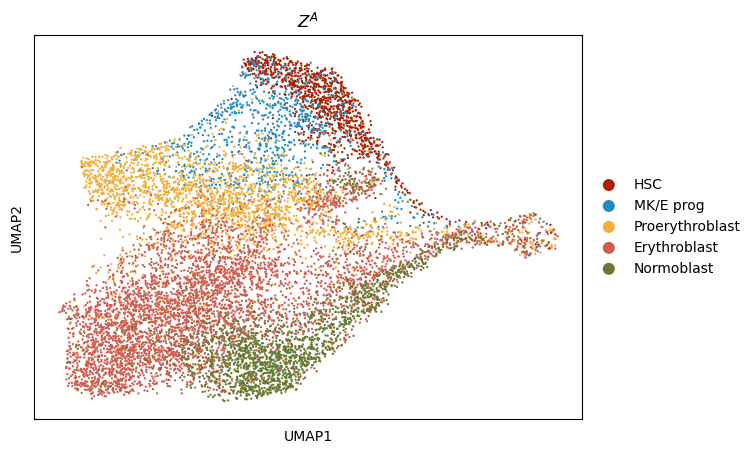

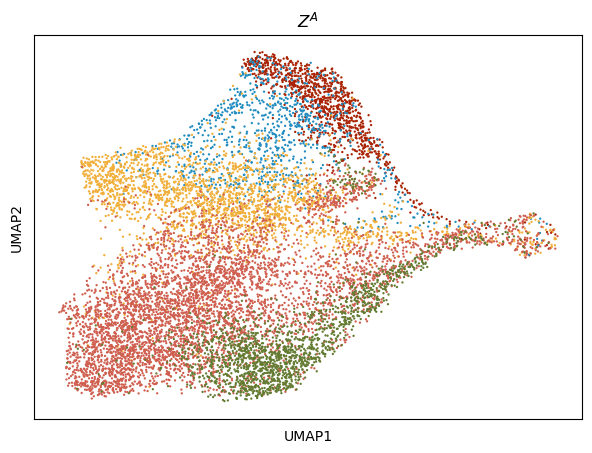

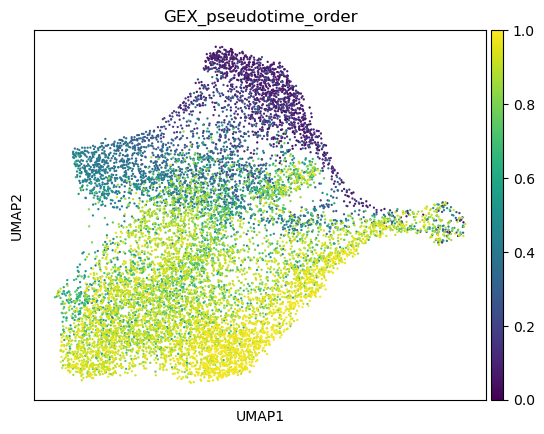

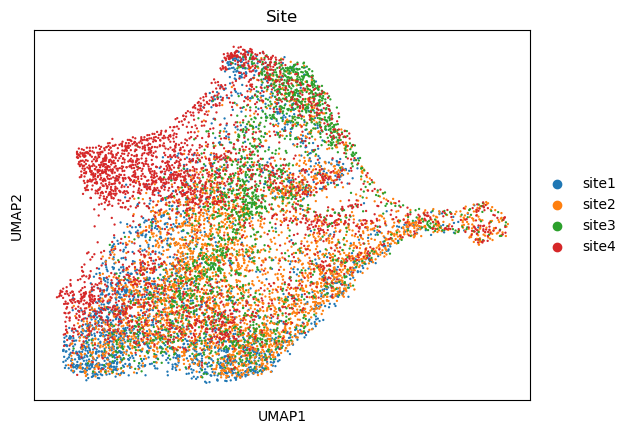

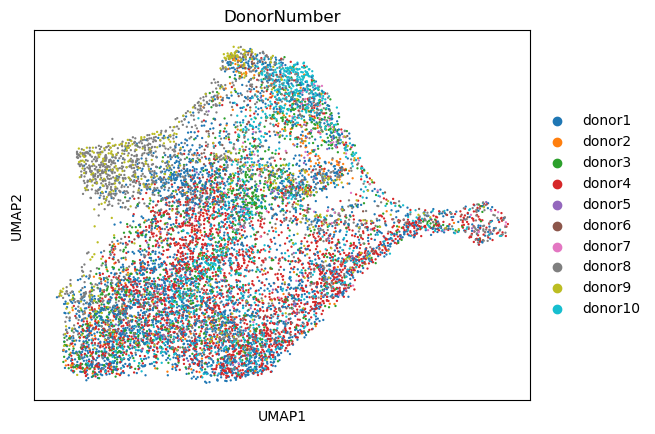

In [13]:
# adata_mvi.obsm["latent"] = latent_acc
# sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

# sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['cell_type'])
sc.pl.scatter(adata_mvi,color='cell_type',basis='umap',title = '$Z^{A}$',palette=colors)
plt.show()


sc.pl.scatter(adata_mvi,color='cell_type',basis='umap',title = '$Z^{A}$',palette=colors,legend_loc = 'none')
plt.show()

sc.pl.umap(adata_mvi, color=['GEX_pseudotime_order'])
plt.show()

sc.pl.umap(adata_mvi, color=['Site'])
plt.show()

sc.pl.umap(adata_mvi, color=['DonorNumber'])
plt.show()

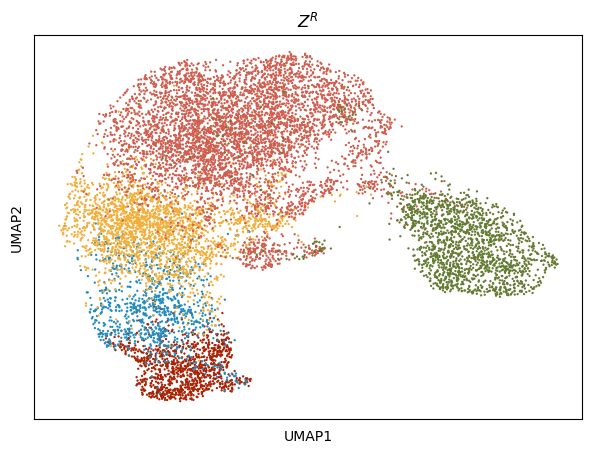

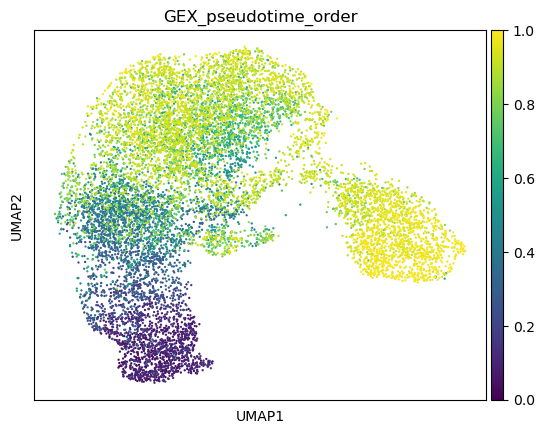

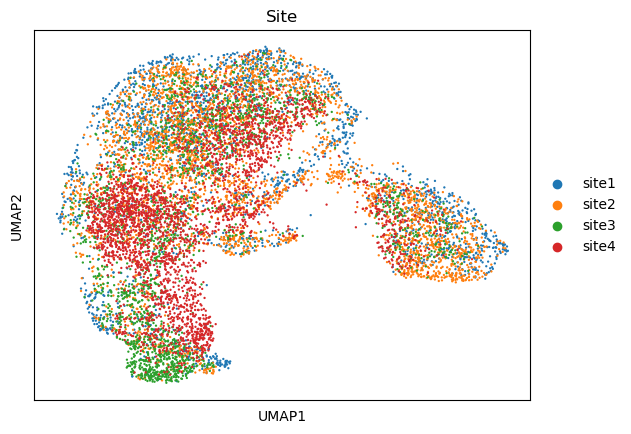

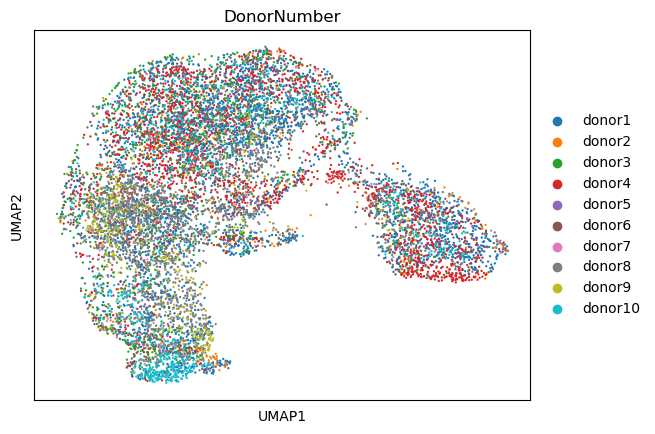

In [14]:
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['cell_type'])
sc.pl.scatter(adata_mvi,color='cell_type',basis='umap',title = '$Z^{R}$',palette=colors)
plt.show()

sc.pl.umap(adata_mvi, color=['GEX_pseudotime_order'])
plt.show()

sc.pl.umap(adata_mvi, color=['Site'])
plt.show()

sc.pl.umap(adata_mvi, color=['DonorNumber'])
plt.show()

In [12]:
model.module.alpha = 0.1
model.module.beta_2 = 1e6
model.module.beta_3 = 1e6
model.module.beta_1 = 1e6
print(model.module.alpha)

0.1


In [13]:
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(2)
model.train(max_epochs=100)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=100 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 33/100:  32%|███▏      | 32/100 [07:34<15:54, 14.04s/it, loss=8.99e+04, v_num=1]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [29]:
model = model.load("model_Neurips_causal_01",adata_mvi)
latent_expr, latent_acc_1,latent_atac_dep, latent_expr_dep, latent_atac_indep, latent_expr_indep, times  = model.get_latent_representation()

INFO     File model_Neurips_causal_01/model.pt already downloaded                            
n_cats_per_cov [4, 10, 13]


In [19]:
model.save("model_Neurips_causal_01",overwrite=True)

In [8]:
latent_expr_1, latent_acc_1,latent_atac_dep_1, latent_expr_dep_1, latent_atac_indep_1, latent_expr_indep_1, times  = model.get_latent_representation()

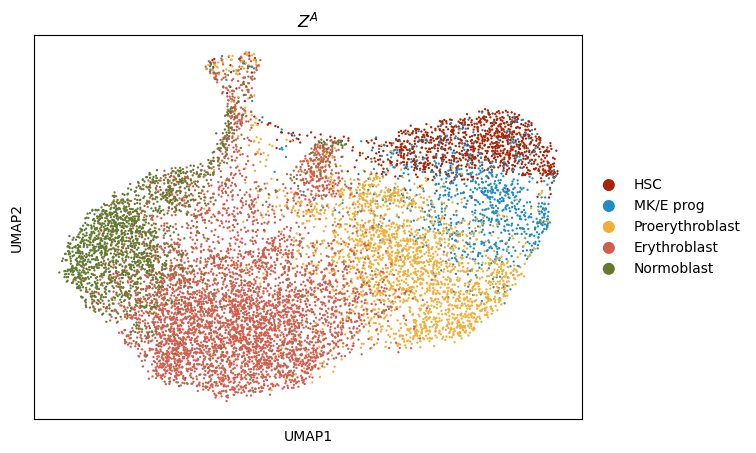

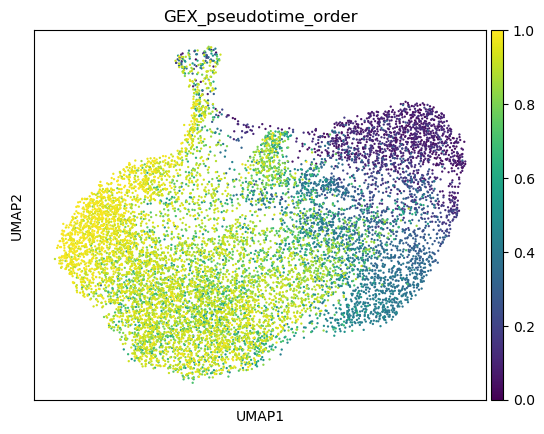

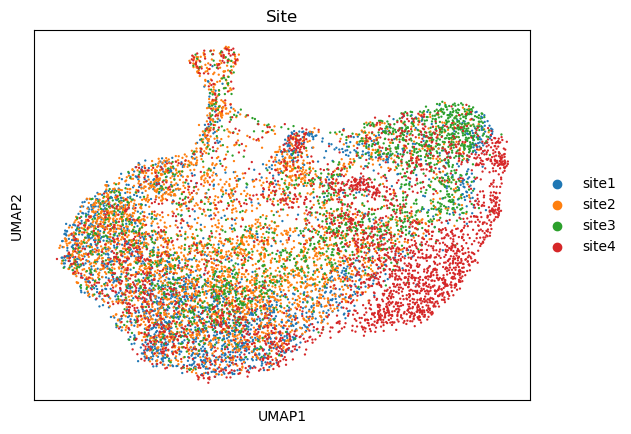

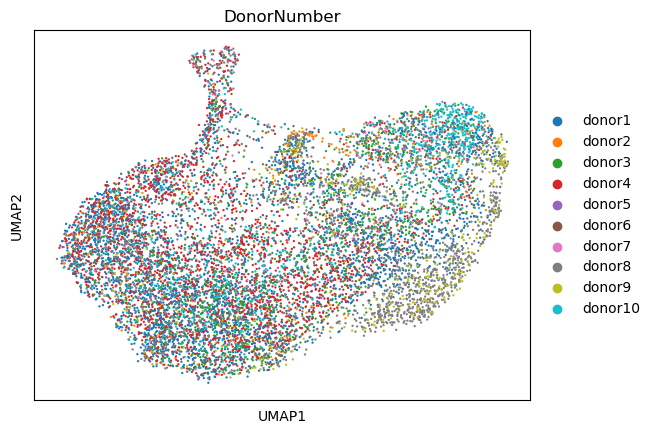

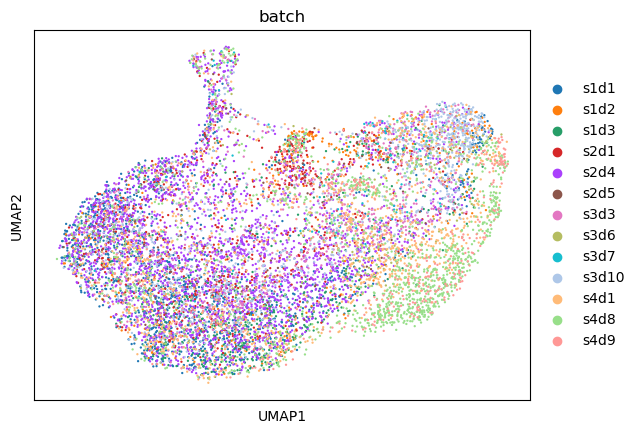

In [18]:
adata_mvi.obsm["latent"] = latent_acc_1
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['cell_type'])
sc.pl.scatter(adata_mvi,color='cell_type',basis='umap',title = '$Z^{A}$',palette=colors)
plt.show()


# sc.pl.scatter(adata_mvi,color='cell_type',basis='umap',title = '$Z^{A}$',palette=colors,legend_loc = 'none')
# plt.show()

sc.pl.umap(adata_mvi, color=['GEX_pseudotime_order'])
plt.show()

sc.pl.umap(adata_mvi, color=['Site'])
plt.show()

sc.pl.umap(adata_mvi, color=['DonorNumber'])
plt.show()

sc.pl.umap(adata_mvi, color=['batch'])
plt.show()

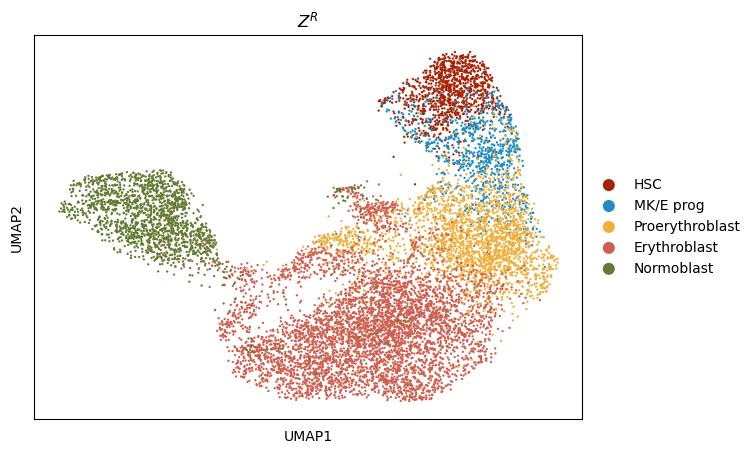

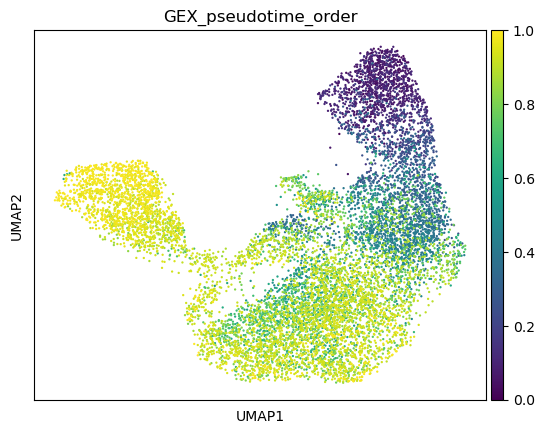

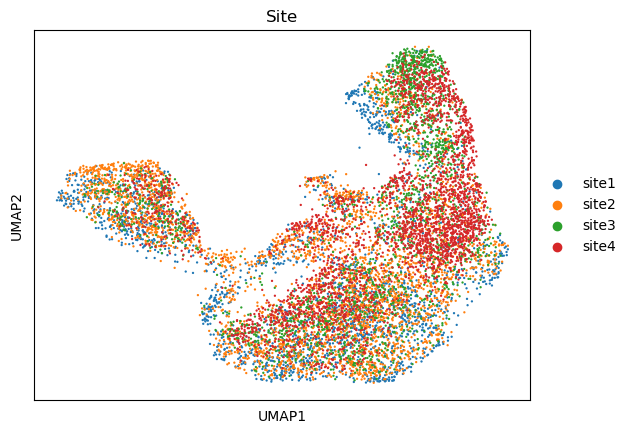

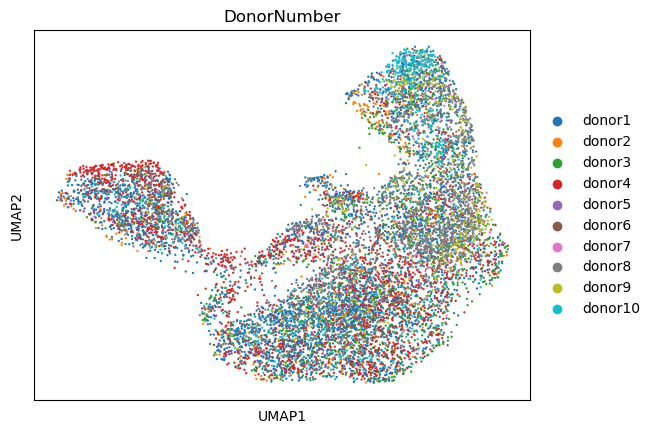

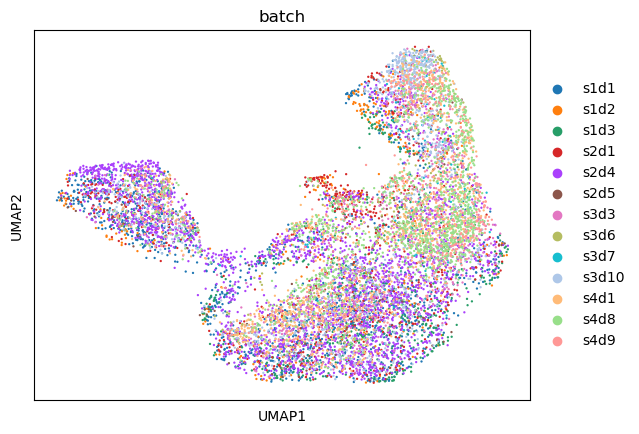

In [17]:
adata_mvi.obsm["latent"] = latent_expr_1
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['cell_type'])
sc.pl.scatter(adata_mvi,color='cell_type',basis='umap',title = '$Z^{R}$',palette=colors)
plt.show()

sc.pl.umap(adata_mvi, color=['GEX_pseudotime_order'])
plt.show()

sc.pl.umap(adata_mvi, color=['Site'])
plt.show()

sc.pl.umap(adata_mvi, color=['DonorNumber'])
plt.show()

sc.pl.umap(adata_mvi, color=['batch'])
plt.show()

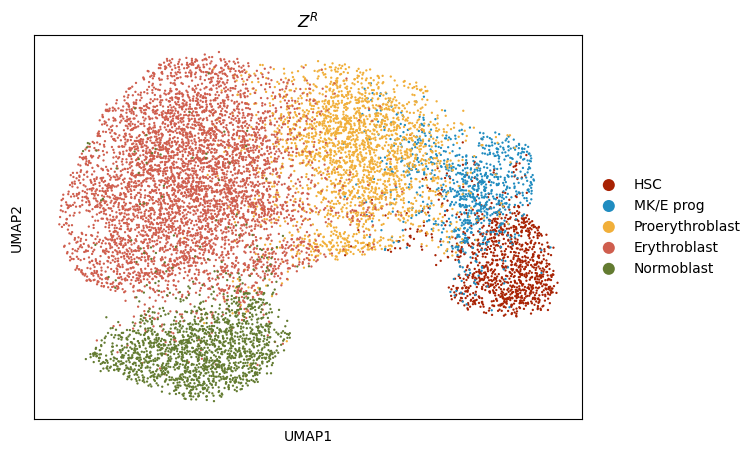

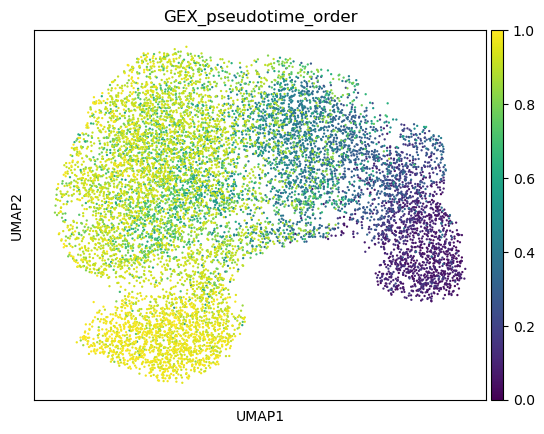

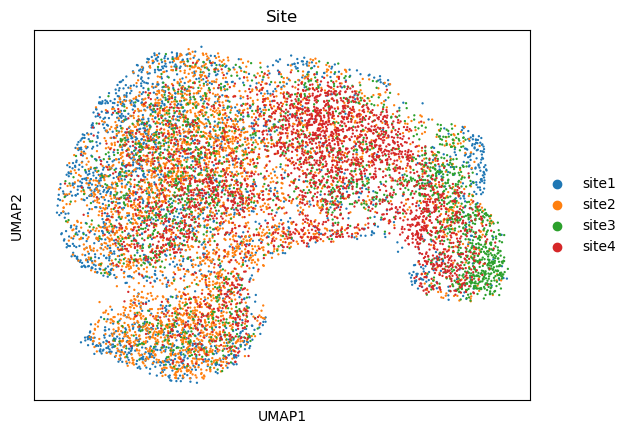

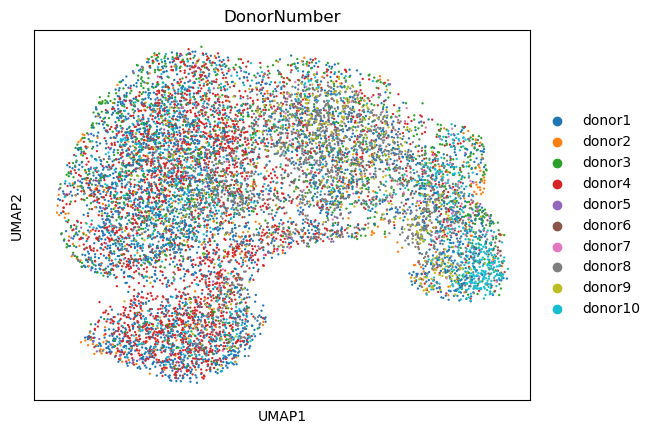

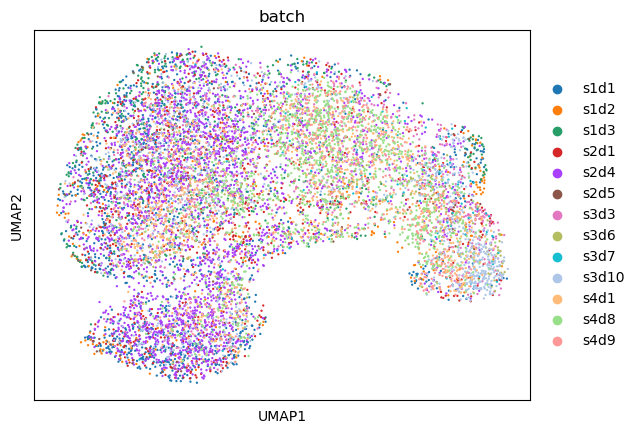

In [26]:
adata_mvi.obsm["latent"] = latent_atac_dep_1
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['cell_type'])
sc.pl.scatter(adata_mvi,color='cell_type',basis='umap',title = '$Z^{R}$',palette=colors)
plt.show()

sc.pl.umap(adata_mvi, color=['GEX_pseudotime_order'])
plt.show()

sc.pl.umap(adata_mvi, color=['Site'])
plt.show()

sc.pl.umap(adata_mvi, color=['DonorNumber'])
plt.show()

sc.pl.umap(adata_mvi, color=['batch'])

In [36]:
adata_mvi.obsm["halo_latent_expr"] = latent_expr
adata_mvi.obsm["halo_latent_atac"] = latent_acc

adata_mvi.obsm["halo_latent_expr_dep"] = latent_expr_dep
adata_mvi.obsm["halo_latent_atac_dep"] = latent_atac_dep

adata_mvi.obsm["halo_latent_expr_indep"] = latent_expr_indep
adata_mvi.obsm["halo_latent_atac_indep"] = latent_atac_indep


In [18]:
import scib

In [43]:
adata_mvi.obsm["halo_latent_expr"] = np.concatenate([latent_expr, latent_acc],axis=1)


In [44]:
sc.pp.neighbors(adata_mvi, use_rep="halo_latent_expr", n_neighbors=25)

# scib.metrics.ilisi_graph(adata_mvi, "batch", "embede", use_rep='halo_latent_atac', k0=90, subsample=None, scale=True, n_cores=1, verbose=False)
# scib.metrics.kBET(adata_mvi,  "batch",  "cell_type", type_="embed", embed="halo_latent_expr", scaled=True, return_df=False, verbose=False)

In [45]:
scib.metrics.graph_connectivity(adata_mvi, "cell_type")

0.9961554329943952

In [32]:
import scib

In [46]:
results = scib.metrics.silhouette_batch(adata_mvi, "batch",  "cell_type","halo_latent_expr")

results

mean silhouette per group:                  silhouette_score
group                            
Erythroblast             0.940018
HSC                      0.892630
MK/E prog                0.924771
Normoblast               0.933455
Proerythroblast          0.924568


0.9230883840921695

In [34]:
results = scib.metrics.silhouette_batch(adata_mvi, "batch",  "cell_type","halo_latent_atac")

results

mean silhouette per group:                  silhouette_score
group                            
Erythroblast             0.912246
HSC                      0.879417
MK/E prog                0.898767
Normoblast               0.887587
Proerythroblast          0.886900


0.8929833654193947

In [41]:
results = scib.metrics.silhouette_batch(adata_mvi, "batch",  "cell_type","halo_latent_expr_indep")

results

mean silhouette per group:                  silhouette_score
group                            
Erythroblast             0.912237
HSC                      0.870692
MK/E prog                0.854104
Normoblast               0.857758
Proerythroblast          0.878023


0.8745627616512988

In [63]:
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
batchlist= adata_mvi.obs["batch"].map(label, na_action='ignore').to_numpy()

In [64]:
dHSIC(latent_atac_indep, batchlist)

0.01137616087708716

In [65]:
dHSIC(latent_expr_indep, batchlist)

0.00275137356411378

In [66]:
dHSIC(latent_expr, batchlist)

0.011924798084344565

In [67]:
dHSIC(latent_acc, batchlist)

0.004661058541078619

In [68]:
dHSIC(latent_atac_dep, batchlist)

0.011879301312850475

In [69]:
dHSIC(latent_expr_dep, batchlist)

0.0061374500800468615

In [71]:
HSIC_glue = [0.01137616087708716, 0.011879301312850475]
np.mean(HSIC_glue)

0.011627731094968816

In [42]:
HSIC = [0.006926510050221378, 0.010728397539008856, 0.01154317323112807, 0.004194704836336837, 0.008697854522466521, 0.008006321824834243]
np.mean(HSIC)

0.008349493667332649

In [26]:
HSIC = [0.006926510050221378, 0.010728397539008856, 0.01154317323112807, 0.004194704836336837, 0.008697854522466521, 0.008006321824834243]
reps = ["latent RNA", "latent ATAC", "latent RNA decouple", "latent ATAC decouple", "latent ATAC couple", "latent RNA couple"]
df = pd.DataFrame({"value": -np.log10(HSIC), "variable": reps})
df

value              variable
0  2.159486            latent RNA
1  1.969465           latent ATAC
2  1.937675   latent RNA decouple
3  2.377299  latent ATAC decouple
4  2.060588    latent ATAC couple
5  2.096567     latent RNA couple

In [ ]:
## sample the data



In [38]:
df.to_csv("Benchmark/halo_hsic_neurips.csv")

<Figure size 1000x1000 with 0 Axes>

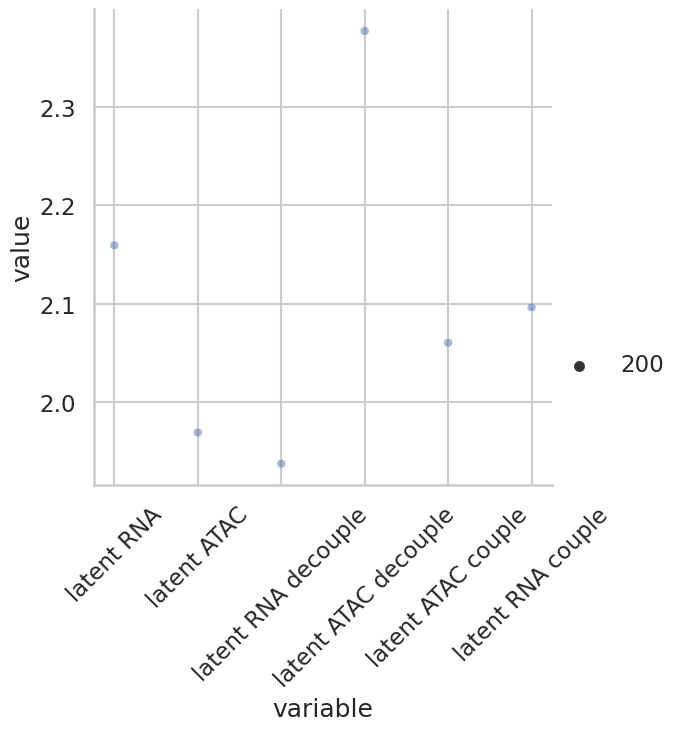

In [36]:
plt.figure(figsize=(10,10))
sns.relplot(x="variable", y="value", size=200,
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)
plt.xticks(rotation=45)
plt.show()            

In [ ]:
testStat, thresh = dHSIC(latent_expr_1, batchlist)
testStat

In [11]:
def batch_latent_HSIC(data1, data2, samplesize, samplenum=20):
    pvalues = []
    for i in range(samplenum):
        indices = np.random.choice(data1.shape[0], size=samplesize, replace=False)
        subdata1 = data1[indices, :]
        subdata2 = data2[indices]
        p = dHSIC(subdata1, subdata2)
        pvalues.append(p)
    return pvalues

In [14]:
df_A = latent_atac_indep_1
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
df_B= adata_mvi.obs["batch"].map(label, na_action='ignore').to_numpy()
atac_decouple_ps = batch_latent_HSIC(df_A, df_B , 5000)



df_A = latent_atac_dep_1
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
df_B= adata_mvi.obs["batch"].map(label, na_action='ignore').to_numpy()
atac_couple_ps = batch_latent_HSIC(df_A, df_B , 5000)

df_A = latent_expr_dep_1
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
df_B= adata_mvi.obs["batch"].map(label, na_action='ignore').to_numpy()
rna_couple_ps = batch_latent_HSIC(df_A, df_B , 5000)


df_A = latent_expr_indep_1
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
df_B= adata_mvi.obs["batch"].map(label, na_action='ignore').to_numpy()
rna_decouple_ps = batch_latent_HSIC(df_A, df_B , 5000)


df_A = latent_expr_1
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
df_B= adata_mvi.obs["batch"].map(label, na_action='ignore').to_numpy()
expr_ps = batch_latent_HSIC(df_A, df_B , 5000)


df_A = latent_acc_1
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
df_B= adata_mvi.obs["batch"].map(label, na_action='ignore').to_numpy()
atac_ps = batch_latent_HSIC(df_A, df_B , 5000)

In [25]:
df_rep1 = pd.DataFrame({"Decouple ATAC": atac_decouple_ps, "Decouple RNA": rna_decouple_ps, "Couple ATAC": atac_couple_ps, "Couple RNA": rna_couple_ps, "RNA": expr_ps, "ATAC": atac_ps})
df_rep1.to_csv("Benchmark/dHSIC_halo.csv")

In [ ]:
df_rep1 = df_rep1.melt(value_vars=["Decouple ATAC", "Decouple RNA", "Couple ATAC", "Couple RNA", "RNA", "ATAC"])
df_rep1

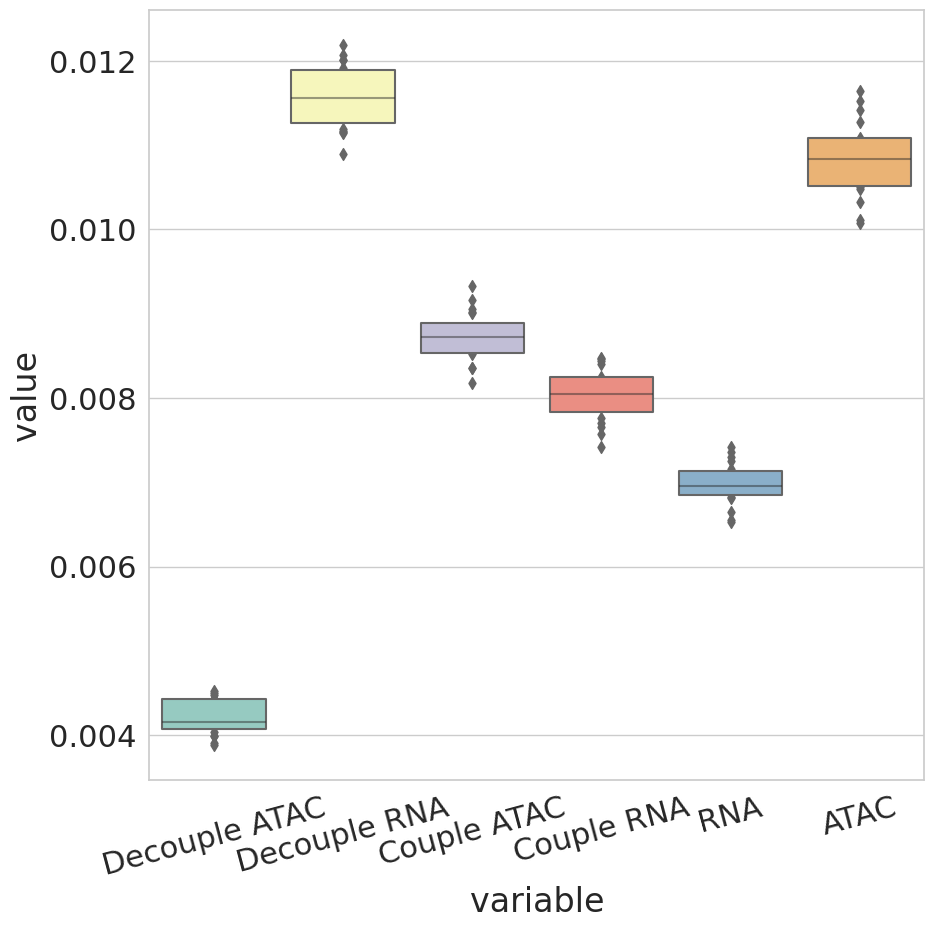

In [24]:
sns.set(font_scale=2, style="whitegrid")

plt.figure(figsize=(10,10))
ax = sns.boxenplot(x='variable', y='value', data=df_rep1, palette="Set3")
plt.xticks(rotation=15)
# plt.ylim(0.3, 0.7)
plt.savefig("Benchmark/batch_rep_halo_hsic.pdf", format="pdf", dpi=300)

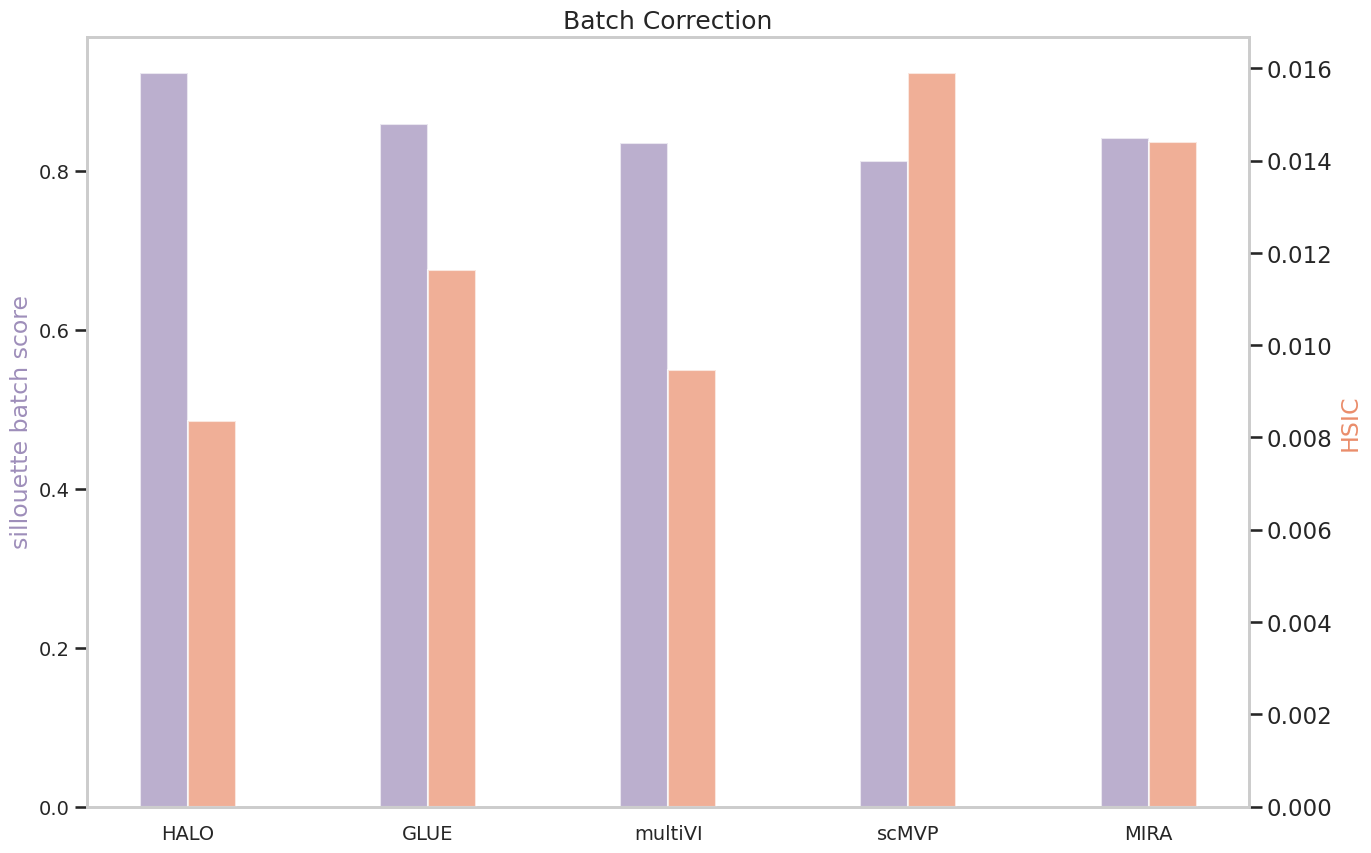

In [75]:
sbatch = [0.923088384,0.859505929,0.835575148,0.812095932,0.842104499]
dHSIC = [0.008349494,0.011627731,0.009463346,0.015890605,0.014404804]
mehotds = ["HALO","GLUE","multiVI", "scMVP", "MIRA"]
sns.set_style("whitegrid", {'axes.grid' : False})
N = len(mehotds)
ind = np.arange(N)  

fig, ax1 = plt.subplots(figsize=(15, 10))
width = 0.2
wd = pd.DataFrame({"methods":mehotds, "sillouette_batch":sbatch, "HSIC":dHSIC})

# Plot the first set of data with bars
bars1 = ax1.bar(ind - width/2, wd['sillouette_batch'], color='#9E8EBA', label='sillouette_batch', alpha=0.7, width=width)
plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' applies changes to both axes

# Create the second y-axis based on the first
ax2 = ax1.twinx()

# Plot the second set of data with bars, offsetting the x positions to avoid overlap
# x_offset = 0.2  # Adjust as necessary for your data and visual preferences
bars2 = ax2.bar(ind, wd['HSIC'], width=width, color='#EA8D6B', alpha=0.7, label='F-norm', align='edge')
ax1.set_xticks(ind)  # Set x-tick positions
ax1.set_xticklabels(["HALO", "GLUE", "multiVI", "scMVP", "MIRA"])
# Set the y-axis labels
ax1.set_ylabel('sillouette batch score', color='#9E8EBA',size=17)
ax2.set_ylabel('HSIC', color='#EA8D6B',size=17)
# plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' applies changes to both axes
# ax2.set_xticklabels(mehotds)
# ax1.set_xticklabels(wd["methods"])
# plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' applies changes to both axes

# Optionally, set the title and legend
plt.title('Batch Correction')
# ax1.legend(loc='upper right')
# ax2.legend(loc='upper right')
plt.savefig("Benchmark/batch.pdf", format="pdf", dpi=300)
# plt.savefig("Benchmark/Dist.png", format="png", dpi=300)

In [85]:
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
df_B= adata_mvi.obs["batch"].map(label, na_action='ignore').to_numpy()

np.savetxt("Benchmark/neurips_halo_latent_expr.txt", latent_expr_1)
np.savetxt("Benchmark/neurips_halo_latent_atac.txt", latent_acc_1)
np.savetxt("Benchmark/neurips_batches.txt", df_B)



In [88]:
adata_mvi

AnnData object with n_obs × n_vars = 10862 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'modality', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'cell_type_colors', 'Site_colors', 'DonorNumber_colors', 'batch_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', '_scvi_extra_categorical_covs', 'latent', 'X_umap', 'halo_latent_expr', 'halo_latent_ata

In [90]:
celltype = adata_mvi.obs["cell_type"].to_numpy()
label = dict(zip(np.unique(celltype), range(len(np.unique(celltype)))))
df_B= adata_mvi.obs["cell_type"].map(label, na_action='ignore').to_numpy()
np.savetxt("Benchmark/neurips_celltypes.txt", df_B)


In [81]:
adata_mvi.write_h5ad("data/datasets/neurips_data_latent.h5ad")

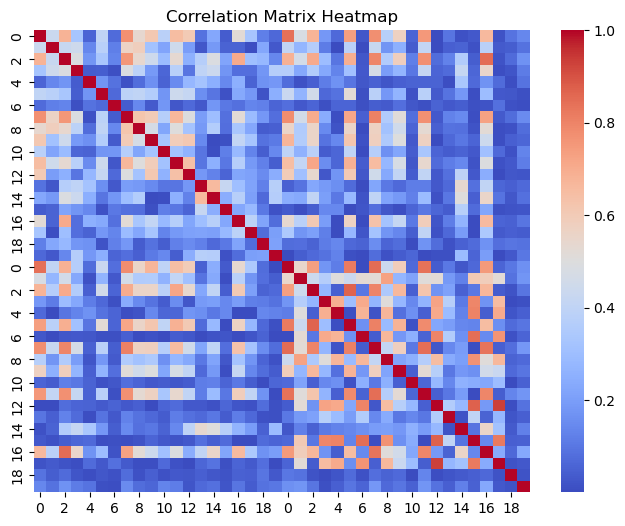

In [25]:
df_A = pd.DataFrame(latent_expr_1)
df_B = pd.DataFrame(latent_acc_1)
df_combined = pd.concat([df_A, df_B], axis=1)
correlation_matrix = df_combined.corr()
plt.figure(figsize=(8, 6))
# sns.heatmap(np.abs(correlation_matrix), annot=False, cmap='coolwarm', fmt=".2f", center=0.0)
sns.heatmap(np.abs(correlation_matrix), annot=False, cmap='coolwarm', fmt=".2f", center=0.5)
plt.title('Correlation Matrix Heatmap')
# plt.savefig("figs/Hair/20_aligned/mouse_latent_corr.png", dpi=300)
plt.show()

In [ ]:
## load mira models

In [61]:
from causallearn.utils.cit import CIT


df_A = latent_atac_indep_1
df_A = latent_expr_indep_1
# df_A = adata_mvi.obs["batch"].to_numpy()

batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
df_B= adata_mvi.obs["batch"].map(label, na_action='ignore')
df_B = np.expand_dims(df_B.to_numpy(),1)
data = np.concatenate([df_A, df_B], axis=1)


array([[ 1.68810636e-01,  1.08872020e+00,  9.08724844e-01, ...,
         2.28665382e-01, -6.92333996e-01,  0.00000000e+00],
       [ 3.56024131e-02,  2.29111814e+00,  8.85709226e-01, ...,
         4.57667679e-01,  1.70919314e-01,  0.00000000e+00],
       [-5.49970334e-03,  9.71758127e-01,  1.00812745e+00, ...,
         4.81557786e-01, -8.97283375e-01,  0.00000000e+00],
       ...,
       [ 4.97327209e-01,  9.65005457e-01,  4.68509555e-01, ...,
         8.63209486e-01,  8.29154491e-01,  1.20000000e+01],
       [ 1.02224326e+00, -1.11206067e+00, -1.23339987e+00, ...,
         8.05997074e-01,  9.60337281e-01,  1.20000000e+01],
       [ 4.75966148e-02,  3.60356539e-01,  1.44764853e+00, ...,
        -5.79770148e-01, -5.11888005e-02,  1.20000000e+01]])

In [65]:
from causallearn.utils.cit import CIT


def batch_latent_CIT(data, samplesize, rep_index, batch_index, samplenum=20):
    pvalues = []
    for i in range(samplenum):
        indices = np.random.choice(data.shape[0], size=samplesize, replace=False)
        subdata = data[indices, :]
        kci_obj = CIT(subdata, "kci") 
        p = kci_obj(rep_index, batch_index)
        pvalues.append(p)
    return pvalues


In [66]:

df_A = latent_atac_indep_1
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
df_B= adata_mvi.obs["batch"].map(label, na_action='ignore')
df_B = np.expand_dims(df_B.to_numpy(),1)
data = np.concatenate([df_A, df_B], axis=1)
atac_decouple_ps = batch_latent_CIT(data, 5000, range(9), 10)



df_A = latent_atac_dep_1
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
df_B= adata_mvi.obs["batch"].map(label, na_action='ignore')
df_B = np.expand_dims(df_B.to_numpy(),1)
data = np.concatenate([df_A, df_B], axis=1)
atac_couple_ps = batch_latent_CIT(data, 5000, range(9), 10)

df_A = latent_expr_dep_1
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
df_B= adata_mvi.obs["batch"].map(label, na_action='ignore')
df_B = np.expand_dims(df_B.to_numpy(),1)
data = np.concatenate([df_A, df_B], axis=1)
expr_couple_ps = batch_latent_CIT(data, 5000, range(9), 10)


df_A = latent_expr_indep_1
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
df_B= adata_mvi.obs["batch"].map(label, na_action='ignore')
df_B = np.expand_dims(df_B.to_numpy(),1)
data = np.concatenate([df_A, df_B], axis=1)
expr_decouple_ps = batch_latent_CIT(data, 5000, range(9), 10)



In [67]:
df_rep1 = pd.DataFrame({"Decouple ATAC": atac_decouple_ps, "Decouple RNA": expr_decouple_ps, "Couple ATAC": atac_couple_ps, "Couple RNA": expr_couple_ps})
df_rep1 = df_rep1.melt(value_vars=["Decouple ATAC", "Decouple RNA", "Couple ATAC", "Couple RNA"])
df_rep1

variable     value
0   Decouple ATAC  0.488818
1   Decouple ATAC  0.490031
2   Decouple ATAC  0.488762
3   Decouple ATAC  0.489878
4   Decouple ATAC  0.489804
..            ...       ...
75     Couple RNA  0.490709
76     Couple RNA  0.489933
77     Couple RNA  0.490131
78     Couple RNA  0.489541
79     Couple RNA  0.489924

[80 rows x 2 columns]

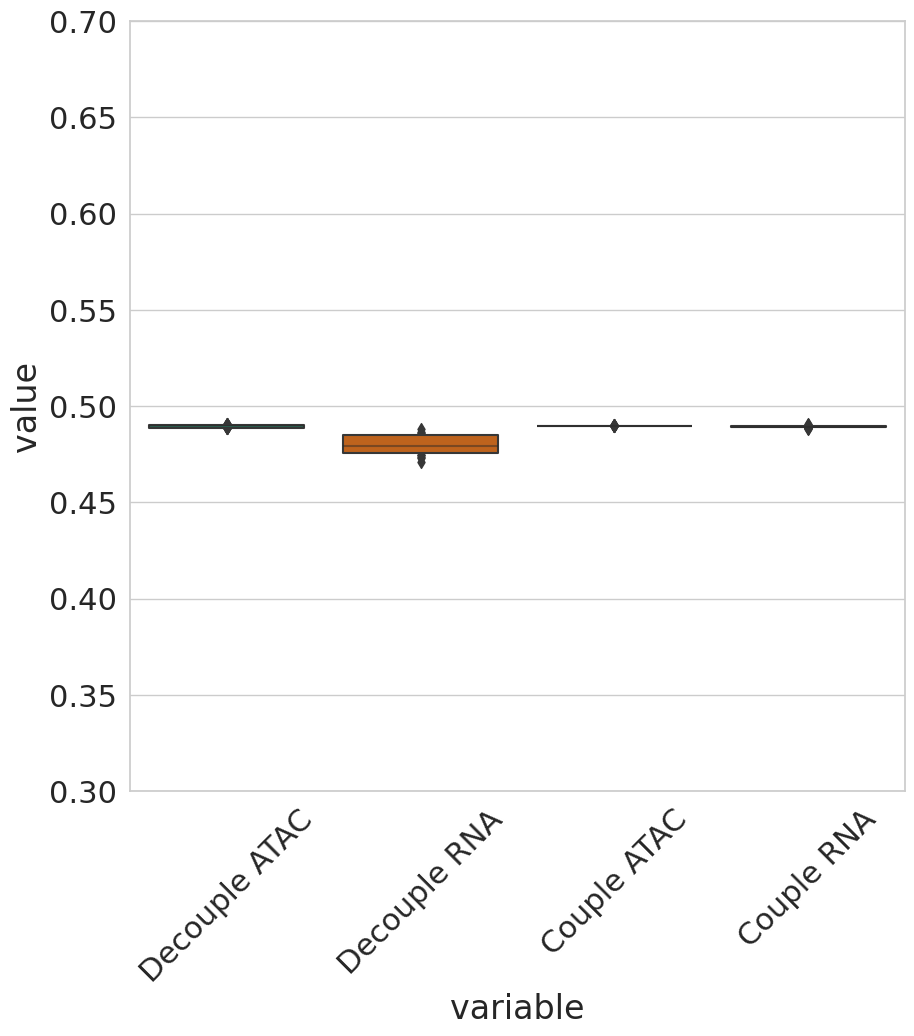

In [80]:
sns.set(font_scale=2, style="whitegrid")

plt.figure(figsize=(10,10))
ax = sns.boxenplot(x='variable', y='value', data=df_rep1, palette="Dark2")
plt.xticks(rotation=45)
plt.ylim(0.3, 0.7)
plt.savefig("Benchmark/batch_rep_indep.pdf", dpi=300)